In [1]:
import requests
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.metrics.pairwise import cosine_similarity
from sentence_transformers import SentenceTransformer
from transformers import pipeline
import matplotlib.pyplot as plt

In [2]:
NEWS_API_KEY = "2090742904994250b1d79117251e88ab"

def fetch_news(query, from_date=None, to_date=None, page_size=50):
    """
    Fetch news articles for a given query using NewsAPI.
    Returns a pandas DataFrame.
    """
    url = "https://newsapi.org/v2/everything"
    params = {
        "q": query,
        "language": "en",
        "sortBy": "publishedAt",
        "pageSize": page_size,
        "apiKey": NEWS_API_KEY
    }
    if from_date:
        params["from"] = from_date
    if to_date:
        params["to"] = to_date

    response = requests.get(url, params=params)
    data = response.json()

    if data.get("status") != "ok":
        print("Error fetching news:", data)
        return pd.DataFrame()

    articles = data.get("articles", [])
    df = pd.DataFrame(articles)
    if not df.empty:
        df["publishedAt"] = pd.to_datetime(df["publishedAt"])
    return df

In [3]:
query = "AI regulation"
news_df = fetch_news(query, page_size=30)
news_df.head()

,source,author,title,description,url,urlToImage,publishedAt,content
0,"{'id': None, 'name': 'Space Daily'}",None,"EU bows to pressure on loosening AI, privacy r...","Brussels, Belgium (AFP) Nov 15, 2025\n\n\n The...",https://www.spacedaily.com/reports/EU_bows_to_...,https://www.spxdaily.com/images-hg/us-flag-whi...,2025-11-16 04:47:14+00:00,"By Raziye AkkocBrussels, Belgium (AFP) Nov 15,..."
1,"{'id': None, 'name': 'Mit.edu'}",Julia Mongo | Distinguished Fellowships,Four from MIT named 2026 Rhodes Scholars,"Four from MIT — Vivian Chinoda ’25, Alice Hall...",https://news.mit.edu/2025/four-mit-named-2026-...,https://news.mit.edu/sites/default/files/image...,2025-11-16 03:00:00+00:00,"Vivian Chinoda 25, Alice Hall, Sofia Lara, and..."
2,"{'id': None, 'name': 'Mercola.com'}",Dr. Mercola,Evolution Didn’t Design You for Long Life — Ca...,Human life today is the result of millions of ...,https://articles.mercola.com/sites/articles/ar...,https://media.mercola.com/ImageServer/Public/2...,2025-11-16 00:00:00+00:00,Mercola proudly supports these charities and o...
3,"{'id': None, 'name': 'Blogspot.com'}",ClassicHasClass,When UPS charged me a $684 tariff on $355 of v...,I try not to write anything even vaguely polit...,http://oldvcr.blogspot.com/2025/11/when-ups-ch...,https://blogger.googleusercontent.com/img/b/R2...,2025-11-15 23:55:19+00:00,I try not to write anything even vaguely polit...
4,"{'id': 'abc-news-au', 'name': 'ABC News (AU)'}",Annabel Crabb,We're trapped in the Attention Olympics — and ...,"When a delegation of ""influencers"" appeared at...",https://www.abc.net.au/news/2025-11-16/annabel...,https://live-production.wcms.abc-cdn.net.au/89...,2025-11-15 18:00:00+00:00,"When a delegation of ""influencers"" appeared at..."


In [4]:
def preprocess_articles(df):
    if df.empty:
        return df

    # Combine title + description + content into one text field
    df["full_text"] = (
        df["title"].fillna("") + ". " +
        df["description"].fillna("") + ". " +
        df["content"].fillna("")
    )

    # Drop rows where text is too short
    df["text_length"] = df["full_text"].str.len()
    df = df[df["text_length"] > 100].copy()

    # Drop duplicate URLs or titles
    df = df.drop_duplicates(subset=["url"])
    df = df.drop_duplicates(subset=["title"])

    # Sort by date
    df = df.sort_values("publishedAt")
    df.reset_index(drop=True, inplace=True)

    return df

news_df = preprocess_articles(news_df)
print(news_df[["source", "author", "title", "publishedAt"]].head())

                                       source                  author  \
0          {'id': None, 'name': 'Biztoc.com'}             reuters.com   
1            {'id': None, 'name': 'Futurism'}             Joe Wilkins   
2       {'id': None, 'name': 'Khabarhub.com'}               Khabarhub   
3  {'id': None, 'name': 'Hollywood Reporter'}  the hollywood reporter   
4                 {'id': None, 'name': 'Vox'}            Sigal Samuel   

                                               title               publishedAt  
0  Walmart CEO Doug McMillon to retire, insider J... 2025-11-14 15:48:07+00:00  
1                  China Is Cracking Down on AI Slop 2025-11-14 16:09:24+00:00  
2                         Today’s News in a Nutshell 2025-11-14 16:15:53+00:00  
3      MS NOW: How Cable News Channel Starts Over... 2025-11-14 17:00:15+00:00  
4  Is AI being shoved down your throat at work? H... 2025-11-14 17:44:24+00:00  


In [5]:
summarizer = pipeline("summarization", model="facebook/bart-large-cnn")

def summarize_text(text, max_length=130, min_length=30):
    text = text.strip()
    if len(text.split()) < 40:
        return text  # too short, no need to summarize
    try:
        summary = summarizer(
            text,
            max_length=max_length,
            min_length=min_length,
            do_sample=False
        )[0]["summary_text"]
        return summary
    except Exception as e:
        print("Summary error:", e)
        return text

def add_article_summaries(df, sample_limit=None):
    """
    Add a 'summary' column for each article.
    sample_limit: if set, only summarize first N articles (for speed in demo).
    """
    summaries = []
    rows = df.iterrows()
    if sample_limit:
        rows = list(df.iterrows())[:sample_limit]

    for idx, row in rows:
        s = summarize_text(row["full_text"])
        summaries.append((idx, s))

    df["summary"] = ""
    for idx, s in summaries:
        df.at[idx, "summary"] = s

    # For any remaining (if sample_limit used), fill with truncated full_text
    empty_summary_mask = df["summary"] == ""
    df.loc[empty_summary_mask, "summary"] = df.loc[empty_summary_mask, "full_text"].str.slice(0, 400)
    return df

news_df = add_article_summaries(news_df, sample_limit=15)  # limit for speed
news_df[["title", "publishedAt", "summary"]].head()

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

Device set to use cuda:0
Your max_length is set to 130, but your input_length is only 83. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=41)
Your max_length is set to 130, but your input_length is only 88. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=44)
Your max_length is set to 130, but your input_length is only 106. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=53)
Your max_length is set to 130, but your input_length is only 121. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer

,title,publishedAt,summary
0,"Walmart CEO Doug McMillon to retire, insider J...",2025-11-14 15:48:07+00:00,"Walmart CEO Doug McMillon to retire, insider J..."
1,China Is Cracking Down on AI Slop,2025-11-14 16:09:24+00:00,The Chinese government is implementing phase t...
2,Today’s News in a Nutshell,2025-11-14 16:15:53+00:00,Kharabhub brings you a glimpse of major develo...
3,MS NOW: How Cable News Channel Starts Over...,2025-11-14 17:00:15+00:00,MSNBC will officially rebrand on Saturday Nov....
4,Is AI being shoved down your throat at work? H...,2025-11-14 17:44:24+00:00,Your Mileage May Vary is an advice column offe...


In [6]:
# Download only once
embedder = SentenceTransformer("all-MiniLM-L6-v2")

def compute_embeddings(texts):
    return embedder.encode(texts, convert_to_numpy=True)

news_df["summary"].fillna(news_df["full_text"].str.slice(0, 400), inplace=True)
embeddings = compute_embeddings(news_df["summary"].tolist())
embeddings.shape


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

/tmp/ipython-input-2921510297.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  news_df["summary"].fillna(news_df["full_text"].str.slice(0, 400), inplace=True)


(27, 384)

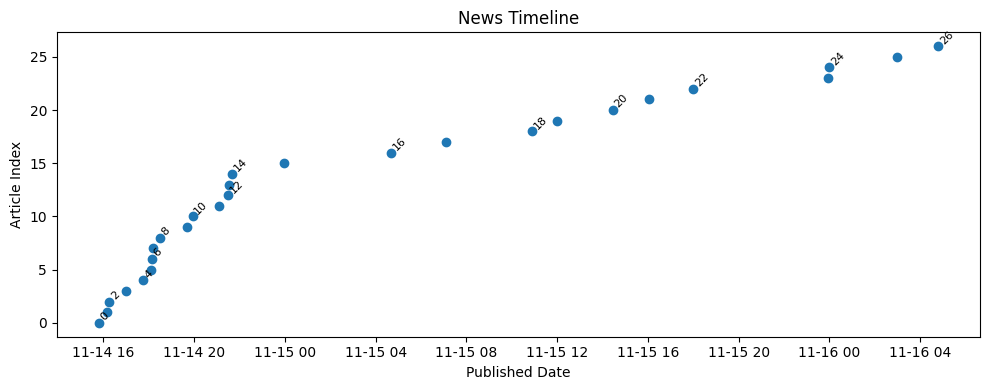

In [7]:
def plot_timeline(df):
    plt.figure(figsize=(10, 4))
    dates = df["publishedAt"]
    y = np.arange(len(df))

    plt.scatter(dates, y)
    for i, (d, title) in enumerate(zip(dates, df["title"])):
        if i % max(1, len(df)//10) == 0:  # label a few points only
            plt.text(d, y[i]+0.2, str(i), rotation=45, fontsize=8)

    plt.title("News Timeline")
    plt.xlabel("Published Date")
    plt.ylabel("Article Index")
    plt.tight_layout()
    plt.show()

plot_timeline(news_df)


In [8]:
def get_central_summaries(df, embeddings, top_k=5):
    # cosine similarity matrix
    sim_matrix = cosine_similarity(embeddings)

    # centrality score = average similarity to others
    centrality = sim_matrix.mean(axis=1)
    df["centrality"] = centrality

    top_indices = np.argsort(-centrality)[:top_k]
    central_summaries = df.iloc[top_indices]["summary"].tolist()
    return central_summaries, df

central_summaries, news_df = get_central_summaries(news_df, embeddings, top_k=5)
central_summaries[:2]


['A team of researchers has uncovered what they say is the first reported use of artificial intelligence to direct a hacking campaign in a largely automated fashion. Anthropic warns of AI-driven hacking campaign linked to China.',
 'EU bows to pressure on loosening AI, privacy rules. Brussels, Belgium (AFP) Nov 15, 2025\n\n\n The European Union is set next week to kickstart a rollback of landmark rules on artificial intelligence and data protection that face powerful pushback on both sides of the Atlantic. \n\nPart of a bid to slash red tape f…. By Raziye AkkocBrussels, Belgium (AFP) Nov 15, 2025\r\nThe European Union is set next we']

In [9]:
def make_consolidated_summary(central_summaries):
    combined_text = " ".join(central_summaries)
    final_summary = summarize_text(combined_text, max_length=220, min_length=80)
    return final_summary

final_summary = make_consolidated_summary(central_summaries)
print("=== CONSOLIDATED EVENT SUMMARY ===\n")
print(final_summary)


=== CONSOLIDATED EVENT SUMMARY ===

EU is set next week to kickstart a rollback of landmark rules on artificial intelligence and data protection. Anthropic warns of AI-driven hacking campaign linked to China. Google Brain founder Andrew Ng thinks you should still learn to code - here's why. ZDNET sat down with Andrew Ng at AI Dev 25 in New York to talk about developer futures, responsible AI, and why AGI is overhyped.


In [10]:
def compute_authenticity(df, embeddings):
    n_articles = len(df)
    if n_articles == 0:
        return 0

    # 1. Source count score (0–40)
    df["source_name"] = df["source"].apply(lambda x: x.get("name") if isinstance(x, dict) else None)
    distinct_sources = df["source_name"].nunique()
    source_count_score = min(40, distinct_sources * 5)  # each source adds 5 points up to 8 sources

    # 2. Publisher diversity score (0–30)
    source_counts = df["source_name"].value_counts(normalize=True)
    max_share = source_counts.iloc[0] if not source_counts.empty else 1.0
    diversity_score = 30 * (1 - max_share)  # if one source dominates, score reduced

    # 3. Agreement score (0–30)
    sim_matrix = cosine_similarity(embeddings)
    # take upper triangle without diagonal
    triu_indices = np.triu_indices_from(sim_matrix, k=1)
    avg_similarity = sim_matrix[triu_indices].mean() if len(triu_indices[0]) > 0 else 0
    # map avg_similarity (0 to 1) -> 0 to 30
    agreement_score = 30 * float(avg_similarity)

    final_score = source_count_score + diversity_score + agreement_score
    final_score = round(min(final_score, 100), 2)

    components = {
        "source_count_score": round(source_count_score, 2),
        "diversity_score": round(diversity_score, 2),
        "agreement_score": round(agreement_score, 2),
        "final_authenticity_score": final_score
    }
    return components

auth_scores = compute_authenticity(news_df, embeddings)
auth_scores


{'source_count_score': 40,
 'diversity_score': np.float64(26.67),
 'agreement_score': 3.96,
 'final_authenticity_score': np.float64(70.63)}

In [11]:
print("=== AUTHENTICITY SCORE ===")
print(f"Source Count Score : {auth_scores['source_count_score']}/40")
print(f"Diversity Score    : {auth_scores['diversity_score']}/30")
print(f"Agreement Score    : {auth_scores['agreement_score']}/30")
print(f"Final Authenticity : {auth_scores['final_authenticity_score']}/100")


=== AUTHENTICITY SCORE ===
Source Count Score : 40/40
Diversity Score    : 26.67/30
Agreement Score    : 3.96/30
Final Authenticity : 70.63/100


In [12]:
def run_news_orchestrator(
    query,
    from_date=None,
    to_date=None,
    page_size=40,
    summarize_limit=15,
    central_k=5
):
    print(f"Fetching news for: {query}")
    df = fetch_news(query, from_date=from_date, to_date=to_date, page_size=page_size)
    if df.empty:
        print("No articles found.")
        return None, None, None, None

    df = preprocess_articles(df)
    if df.empty:
        print("No usable articles after preprocessing.")
        return None, None, None, None

    print(f"Total articles after cleaning: {len(df)}")
    df = add_article_summaries(df, sample_limit=summarize_limit)
    embeds = compute_embeddings(df["summary"].tolist())
    central_summaries, df = get_central_summaries(df, embeds, top_k=central_k)
    final_summary = make_consolidated_summary(central_summaries)
    auth_scores = compute_authenticity(df, embeds)

    return df, final_summary, auth_scores, embeds


🔍 Enter topic to analyze news: Nvidia AI chips
Fetching news for: Nvidia AI chips
Fetching news for: Nvidia AI chips
Total articles after cleaning: 39


Your max_length is set to 130, but your input_length is only 112. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=56)
Your max_length is set to 130, but your input_length is only 116. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=58)
Your max_length is set to 130, but your input_length is only 103. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=51)
Your max_length is set to 130, but your input_length is only 110. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=55)



=== FINAL CONSOLIDATED SUMMARY ===

Nvidia (NVDA) has beaten Wall Street earnings estimates 90% of the time over the past five years. Top Nvidia customers, including Google, Amazon, and Microsoft, are all developing their own AI chips to reduce their dependence on the chip giant. Google will invest $40 billion in Texas data centers. These investments signal a massive scaling up of computing p…. Alphabet's Google unit will invest over  Simply Put: AI bubble and the depreciation debate. Two friends discuss Michael Burry's controversial tweet on AI stocks.

=== AUTHENTICITY SCORE ===

{'source_count_score': 40, 'diversity_score': np.float64(26.15), 'agreement_score': 8.6, 'final_authenticity_score': np.float64(74.76)}

Sample of articles:


,publishedAt,source_name,title
0,2025-11-14 14:46:00+00:00,GlobeNewswire,Semiconductor Chip Market to Grow 16.1% Annual...
1,2025-11-14 15:26:27+00:00,Biztoc.com,Prediction: Bitcoin Will Be Worth More Than Nv...
2,2025-11-14 15:32:00+00:00,24/7 Wall St.,Nvidia Reports Earnings Next Week. How Big of ...
3,2025-11-14 15:36:08+00:00,The Daily Caller,EXCLUSIVE: Sen. Banks ‘Very Suspicious’ Of Nvi...
4,2025-11-14 16:04:23+00:00,The Times of India,'Big Short' fame Michael Burry’s depreciation ...
5,2025-11-14 16:57:47+00:00,Storagereview.com,Dell Pro Max 16 Review: Ryzen AI 9 HX 370 and ...
6,2025-11-14 17:21:57+00:00,The Times of India,Michael Burry called it: AI darlings tank just...
7,2025-11-14 17:39:06+00:00,Wccftech,Intel–OpenAI Partnership Is Possible but “Unli...
8,2025-11-14 18:42:55+00:00,Jeffgeerling.com,Minisforum Stuffs Entire Arm Homelab in the MS-R1
9,2025-11-14 19:44:11+00:00,Investopedia,Morgan Stanley Labels This Memory Chip Maker a...


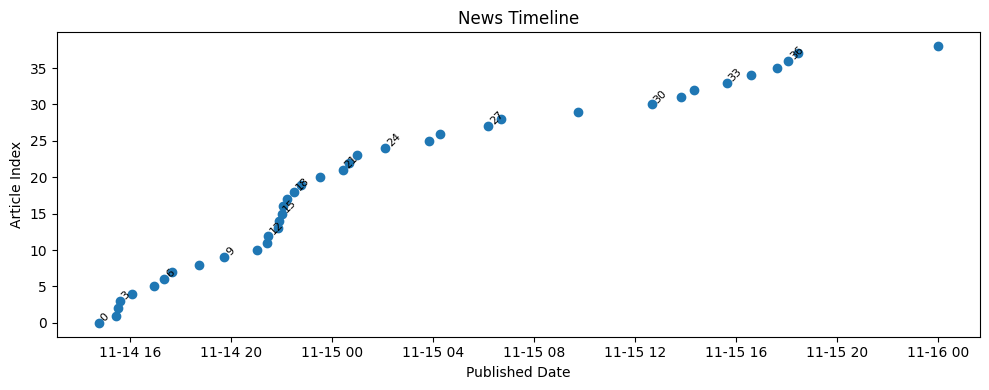

In [19]:
topic = input("🔍 Enter topic to analyze news: ")
print("Fetching news for:", topic)
df_result, consolidated_summary, authenticity_scores, embeddings = run_news_orchestrator(
    topic,
    page_size=40,
    summarize_limit=15,
    central_k=5
)

if df_result is not None:
    print("\n=== FINAL CONSOLIDATED SUMMARY ===\n")
    print(consolidated_summary)
    print("\n=== AUTHENTICITY SCORE ===\n")
    print(authenticity_scores)
    print("\nSample of articles:")
    display(df_result[["publishedAt", "source_name", "title"]].head(10))
    plot_timeline(df_result)


In [1]:
import torch
print(torch.cuda.is_available())


True
